In [ ]:
!pip install kmodes -q

In [8]:
# Cell 1: Imports e Carregamento

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

In [2]:
# Cell 2: Load Processed Data

try:

	input_file = "../data/df_final_processed.pkl"
	print(f"Loaging data: {input_file} ...")

	df_final = pd.read_pickle(input_file)

	print(f"{df_final.shape}")
	print(df_final.head().T)
	print(df_final.tail().T)

except FileNotFoundError:
	
	print(f"Error: File '{input_file}' not found.")
	exit(1)

Loaging data: ../data/df_final_processed.pkl ...
(2122338, 35)
                                              0                        1  \
dia_semana                        Segunda-Feira            Segunda-Feira   
data_hora                   2007-06-11 15:30:00      2007-06-11 15:30:00   
uf                                           MG                       MG   
br                                          381                      381   
km                                        623.2                    623.2   
municipio                              Oliveira                 Oliveira   
causa_acidente          Falta De Atenção/Reação  Falta De Atenção/Reação   
tipo_acidente                   Colisão Frontal          Colisão Frontal   
classificacao_acidente                      Nan                      Nan   
fase_dia                              Pleno Dia                Pleno Dia   
sentido_via                         Decrescente              Decrescente   
condicao_metereologica   

In [3]:
# Cell . Preparing Data for Cluster A (K-Prototypes)

cols_cluster_A = [
    
	'pessoas',
    'veiculos',
    
	'fase_dia',
    'dia_semana',
    'tipo_pista',
    'condicao_metereologica',
    'tipo_acidente',
    
	'feat_curve',
	'feat_relief',
	'feat_structure',
	'feat_intersection',
	'feat_roadwork',

]

df_cluster_A = df_final[ cols_cluster_A ].copy()
df_cluster_A = df_cluster_A.dropna()

print(f"\nCluster A - Shape: {df_cluster_A.shape}\n")

# Indentify indexes from categorial columns - necessary for K-Prototypes
cat_cols = [ df_cluster_A.columns.get_loc(c) for c in df_cluster_A.select_dtypes( include = ['object', 'category'] ).columns ]

# Normilize numeric columns
scaler = StandardScaler()

cols_numeric = df_cluster_A.select_dtypes( include = [np.number] ).columns
df_cluster_A[ cols_numeric ] = scaler.fit_transform( df_cluster_A[ cols_numeric ] )

print(f"\nCategorial Columns Indexes for K-Prototypes: {cat_cols}\n")


Cluster A - Shape: (2122328, 12)


Categorial Columns Indexes for K-Prototypes: [2, 3, 4, 5, 6]




* Calculating costs for different K values...



100%|██████████| 8/8 [43:13<00:00, 324.14s/it]


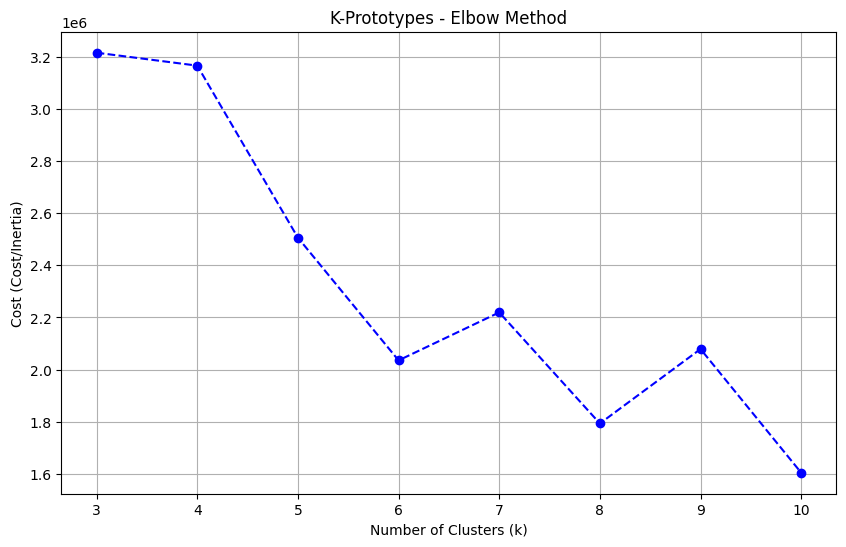

In [4]:
# Cell . Elbow Method to Find Optimal K for K-Prototypes

df_sample = df_cluster_A.sample( n = 500000, random_state = 42 )	# Sample for faster computation

# Convert to numpy array - preferred format for K-Prototypes
X_sample = df_sample.values

cost = []

# K_range = range( 1, 25 )
K_range = range( 3, 11 )

print("\n* Calculating costs for different K values...\n")

for k in tqdm( K_range ):
    
	try:

		kproto = KPrototypes( n_clusters = k, init = 'Cao', n_init = 1, verbose = 0, random_state = 42, n_jobs = -1 )
		kproto.fit( X_sample, categorical = cat_cols )
		cost.append( kproto.cost_ )

	except Exception as e:

		print(f"Error for k={k}: {e}")
		break

plt.figure(figsize=(10, 6))
plt.plot(K_range, cost, marker='o', linestyle='--', color='b')
plt.title('K-Prototypes - Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Cost/Inertia)')
plt.grid(True)
plt.show()

<!-- inserir imagem do cluster -->
Treinamento com n = 500000, de range de 1 a 25

![Texto alternativo](../img/elbow_method.png)

In [5]:
# Cell: Final Clustering Model Application (Cluster A)

# K defind from Elbow Method
K_FINAL = 6

print(f"* K = {K_FINAL}. Processing {len(df_cluster_A)} records...")

# Convert DataFrame to numpy array for K-Prototypes
matrix_full = df_cluster_A.values

# Model Initialization
# init	 = 'Cao': Optmized initialization method for K-Prototypes
# n_jobs = -1: Usees all available CPU cores for parallel processing
# n_init = 3: Model will be run 3 times with different centroid seeds
kproto_final = KPrototypes( n_clusters = K_FINAL, init = 'Cao', n_init = 3, verbose = 1, random_state = 42, n_jobs = -1)

# 4. Train and Predict (Fit & Predict)
clusters = kproto_final.fit_predict( matrix_full, categorical = cat_cols )

# 5. Vefify and Save Results
if 'clusters' in locals():
    print("\n* Saving the generated clusters...")
    
    # Cria uma Série alinhada com o índice original
    cluster_series = pd.Series(clusters, index = df_cluster_A.index, name='cluster_A')
    
    # Faz o join ou atribuição direta
    df_final['cluster_A'] = cluster_series
    
    # Fill the nulls (the 10 problematic rows) with a default value, e.g., -1 (Noise)
    df_final['cluster_A'] = df_final['cluster_A'].fillna(-1).astype(int)

    print("\n* Final distribution:")
    print(df_final['cluster_A'].value_counts().sort_index())

else:
    print("\n* Error: The variable 'clusters' is not in memory.")

* K = 6. Processing 2122328 records...
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3

* Saving the generated clusters...

* Final distribution:
cluster_A
-1         10
 0      72001
 1      20012
 2     408881
 3    1355147
 4     114841
 5     151446
Name: count, dtype: int64


In [7]:
# Cell: Cluster Profiling & Interpretation

def analisar_perfil_clusters(df, cluster_col='cluster_A'):
    """
    Generates a detailed report of the characteristics of each cluster.
    """
    # Using original (non-normalized) columns for human-readable insights
    numeric_profile = df.groupby(cluster_col).agg({
        
        'mortos': 'mean',
        'feridos_graves': 'mean',
        'veiculos': 'mean',
        'pessoas': 'mean',
        'feat_curve': 'mean',      		# % of accidents in curves
        'feat_relief': 'mean',     		# % of accidents in relief
        'feat_structure': 'mean',		# % in bridges/tunnels
        'feat_intersection': 'mean',	# % in intersections (retornos, cruzamentos, etc)
        'feat_roadwork': 'mean',  		# % in roadworks/diversions
        
    }).round(2)
    
    # Add count
    numeric_profile['count'] = df[cluster_col].value_counts()
    numeric_profile['%_total'] = (numeric_profile['count'] / len(df) * 100).round(1)
    
    # 2. Categorical Grouping (Mode - Most Frequent)
    # Lambda function to get the most frequent value
    get_mode = lambda x: x.mode()[0] if not x.mode().empty else "N/A"
    
    cat_cols = ['fase_dia', 'dia_semana', 'tipo_acidente', 'causa_acidente', 'tipo_pista', 'condicao_metereologica']
    cat_profile = df.groupby(cluster_col)[cat_cols].agg(get_mode)
    
    # Show the profile of each cluster
    print(f"\n* CLUSTERS (Total: {len(df)} records)")
    
    for i in numeric_profile.index:
        print(f"\n**CLUSTER {i} ({numeric_profile.loc[i, '%_total']}% of data) ---")
        
        # Estatísticas de Gravidade
        mortos = numeric_profile.loc[i, 'mortos']
        feridos = numeric_profile.loc[i, 'feridos_graves']
        veic = numeric_profile.loc[i, 'veiculos']
        
        print(f"Severity: Average of {mortos} deaths and {feridos} serious injuries.")
        print(f"Involved: Average of {veic} vehicles.")
        
        # Geometry (If the value is high, highlight)
        if numeric_profile.loc[i, 'feat_curve'] > 0.4: print(f"HIGH incidence in CURVES ({numeric_profile.loc[i, 'feat_curve']*100:.0f}%)")
        if numeric_profile.loc[i, 'feat_intersection'] > 0.4: print(f"HIGH incidence in INTERSECTIONS")
        
        # Categorical Pattern
        print(f"When: {cat_profile.loc[i, 'fase_dia']} | {cat_profile.loc[i, 'dia_semana']}")
        print(f"Weather: {cat_profile.loc[i, 'condicao_metereologica']}")
        print(f"What: {cat_profile.loc[i, 'tipo_acidente']} ({cat_profile.loc[i, 'causa_acidente']})")
        print(f"Road: {cat_profile.loc[i, 'tipo_pista']}")

    return numeric_profile.join(cat_profile)

# Execute
perfil_clusters = analisar_perfil_clusters(df_final)

# Show the profile of each cluster with color highlighting for 'mortos' and 'feridos_graves'
perfil_clusters.style.background_gradient(cmap='Reds', subset=['mortos', 'feridos_graves'])


* CLUSTERS (Total: 2122338 records)

**CLUSTER -1 (0.0% of data) ---
Severity: Average of 0.0 deaths and 0.0 serious injuries.
Involved: Average of 1.3 vehicles.
When: Pleno Dia | Sábado
Weather: Céu Claro
What: Colisão Transversal (Outras)
Road: N/A

**CLUSTER 0 (3.4% of data) ---
Severity: Average of 0.1 deaths and 0.27 serious injuries.
Involved: Average of 2.03 vehicles.
When: Pleno Dia | Domingo
Weather: Céu Claro
What: Saída De Leito Carroçável (Falta De Atenção/Reação)
Road: Simples

**CLUSTER 1 (0.9% of data) ---
Severity: Average of 0.07 deaths and 0.26 serious injuries.
Involved: Average of 2.04 vehicles.
When: Pleno Dia | Sábado
Weather: Céu Claro
What: Colisão Traseira (Falta De Atenção/Reação)
Road: Simples

**CLUSTER 2 (19.3% of data) ---
Severity: Average of 0.05 deaths and 0.16 serious injuries.
Involved: Average of 1.42 vehicles.
HIGH incidence in CURVES (100%)
When: Pleno Dia | Domingo
Weather: Céu Claro
What: Saída De Pista (Outras)
Road: Simples

**CLUSTER 3 (63.9%

,mortos,feridos_graves,veiculos,pessoas,feat_curve,feat_relief,feat_structure,feat_intersection,feat_roadwork,count,%_total,fase_dia,dia_semana,tipo_acidente,causa_acidente,tipo_pista,condicao_metereologica
cluster_A,,,,,,,,,,,,,,,,,
-1,0.000000,0.000000,1.300000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,10,0.000000,Pleno Dia,Sábado,Colisão Transversal,Outras,N/A,Céu Claro
0,0.100000,0.270000,2.030000,2.590000,0.250000,1.000000,0.000000,0.040000,0.000000,72001,3.400000,Pleno Dia,Domingo,Saída De Leito Carroçável,Falta De Atenção/Reação,Simples,Céu Claro
1,0.070000,0.260000,2.040000,2.540000,0.110000,0.160000,0.590000,0.090000,0.430000,20012,0.900000,Pleno Dia,Sábado,Colisão Traseira,Falta De Atenção/Reação,Simples,Céu Claro
2,0.050000,0.160000,1.420000,1.810000,1.000000,0.000000,0.000000,0.000000,0.000000,408881,19.300000,Pleno Dia,Domingo,Saída De Pista,Outras,Simples,Céu Claro
3,0.050000,0.170000,1.730000,2.050000,0.000000,0.000000,0.000000,0.000000,0.000000,1355147,63.900000,Pleno Dia,Sexta-Feira,Colisão Traseira,Falta De Atenção/Reação,Simples,Céu Claro
4,0.210000,0.530000,3.650000,5.950000,0.120000,0.010000,0.000000,0.000000,0.000000,114841,5.400000,Pleno Dia,Domingo,Colisão Traseira,Falta De Atenção/Reação,Simples,Céu Claro
5,0.020000,0.170000,1.940000,2.300000,0.010000,0.000000,0.000000,1.000000,0.000000,151446,7.100000,Pleno Dia,Sexta-Feira,Colisão Transversal,Falta De Atenção/Reação,Simples,Céu Claro


In [ ]:
# Cell 5: Save Data with Clusters

OUTPUT_PATH = "../data/df_final_with_cluster_A.pkl"

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

print("\n* Saving final DataFrame...")
df_final.to_pickle(OUTPUT_PATH)

print(f"\n* File saved at: {OUTPUT_PATH}")


* Saving final DataFrame...

* File saved at: ../data/df_final_processed_cluster_A.pkl
